### 학습목표
1. 푸쉬 노티피케이션 타임 의사 결정 하기

In [1]:
import numpy as np
import pandas as pd
# seaborn
import seaborn as sns
COLORS = sns.color_palette()

%matplotlib inline

In [2]:
def plot_bar(df, xlabel, ylabel, title, figsize=(20, 10), color=COLORS[-1], rotation=45):
    plot = df.plot(kind='bar', color=color, figsize=figsize)
    plot.set_xlabel(xlabel, fontsize=10)
    plot.set_ylabel(ylabel, fontsize=10)
    plot.set_title(title, fontsize=12)
    plot.set_xticklabels(labels=df.index, rotation=rotation)

In [4]:
dtypes = {
    'UnitPrice': np.float32,
    'CustomerID': np.int32,
    'Quantity': np.int32
}
retail = pd.read_csv('./data/OnlineRetailClean.csv', dtype=dtypes)
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], infer_datetime_format=True)
retail.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### 쿠폰 발송을 할때, push를 언제 보내는게 좋을까?
 - 고객에게 쿠폰 발송을 한다고 기획하고, 회의를 한다고 가정해보겠습니다. 
  - A: 쿠폰을 언제보내는게 좋을까요?
  - B: 아침에 출퇴근 시간에 보내는게 좋을까요?
  - C: 점심 먹고 졸린데 그때 보내보죠?
  - D: 흠 자기전에 스마트폰 많이 하던데 그때는 어떨까요?
  - A: 그러면 평균 시간을 내볼까요?
  - K: 아 **데이터**를 확인해보는게 맞지 않을까요? 언제 고객이 주로 주문을 하는지? 


 - 위에서 처럼 실제로 회의를 하다보면 의사결정이 본인/주변의 경험에 의해서 이뤄지는 것을 많이 볼 수 있습니다. 
 - 주문이 이뤄지는 시간을 고려하지 않고 막무가내로 보낸다면 아무 의미가 없고, 추후 같은 이벤트 발생시에도 판단 근거가 없게 됨
 - 현상태에서는 가장 많이 주문이 일어나는 시점에서 하는 것이 가장 직관적인 판단
   - 1. 데이터로 파악
   - 2. 가설 제시
   - 3. 가설 검증
   - 4. 1-3 반복
 - 시간(hour, minute)과 주로 관련되기 때문에 역시 InvoiceDate가 중요한 feature
   

In [6]:
order_by_hour = retail.set_index('InvoiceDate').groupby(lambda date: date.hour).count()['CustomerID']
order_by_hour

InvoiceDate
6         1
7       379
8      8690
9     21944
10    37997
11    49084
12    72065
13    64026
14    54118
15    45369
16    24089
17    13071
18     2928
19     3321
20      802
Name: CustomerID, dtype: int64

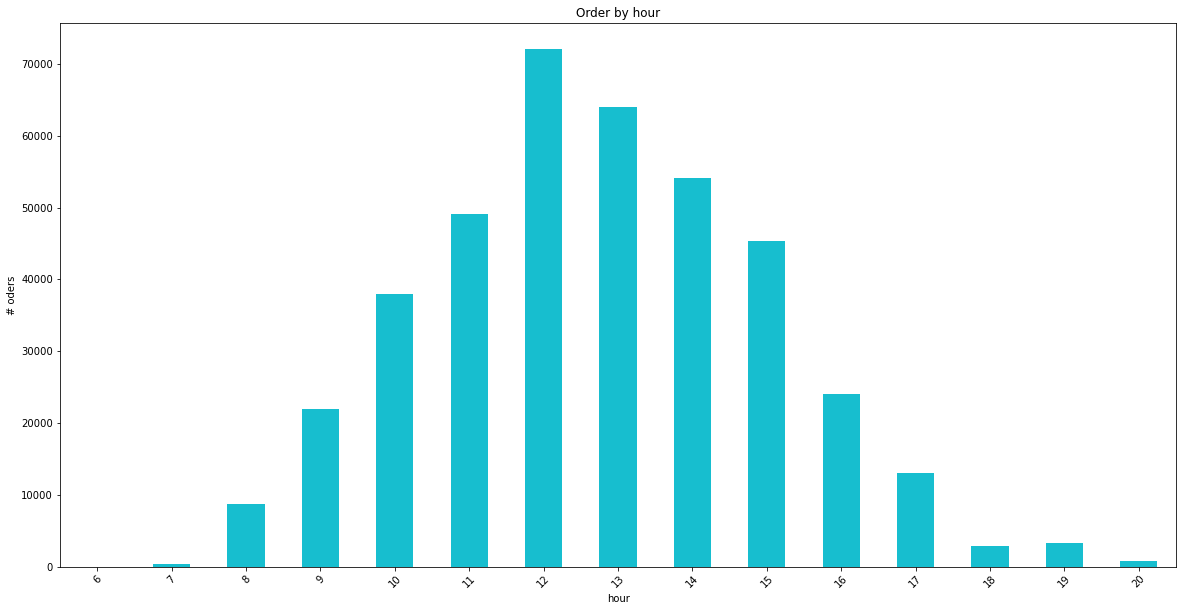

In [7]:
plot_bar(order_by_hour, 'hour', '# oders', 'Order by hour')

In [8]:
def half_an_hour(date):
    minute = ':00'
    if date.minute > 30:
        minute = ':30'
    hour = str(date.hour)
    if date.hour < 10:
        hour = '0' + hour
        
    return hour + minute

In [10]:
order_by_hour_half = retail.set_index('InvoiceDate').groupby(half_an_hour).count()['CustomerID']
order_by_hour_half

InvoiceDate
06:00        1
07:30      379
08:00     3145
08:30     5545
09:00     9364
09:30    12580
10:00    16950
10:30    21047
11:00    18925
11:30    30159
12:00    37174
12:30    34891
13:00    31131
13:30    32895
14:00    26958
14:30    27160
15:00    24227
15:30    21142
16:00    14316
16:30     9773
17:00     8889
17:30     4182
18:00     1715
18:30     1213
19:00     1534
19:30     1787
20:00      802
Name: CustomerID, dtype: int64

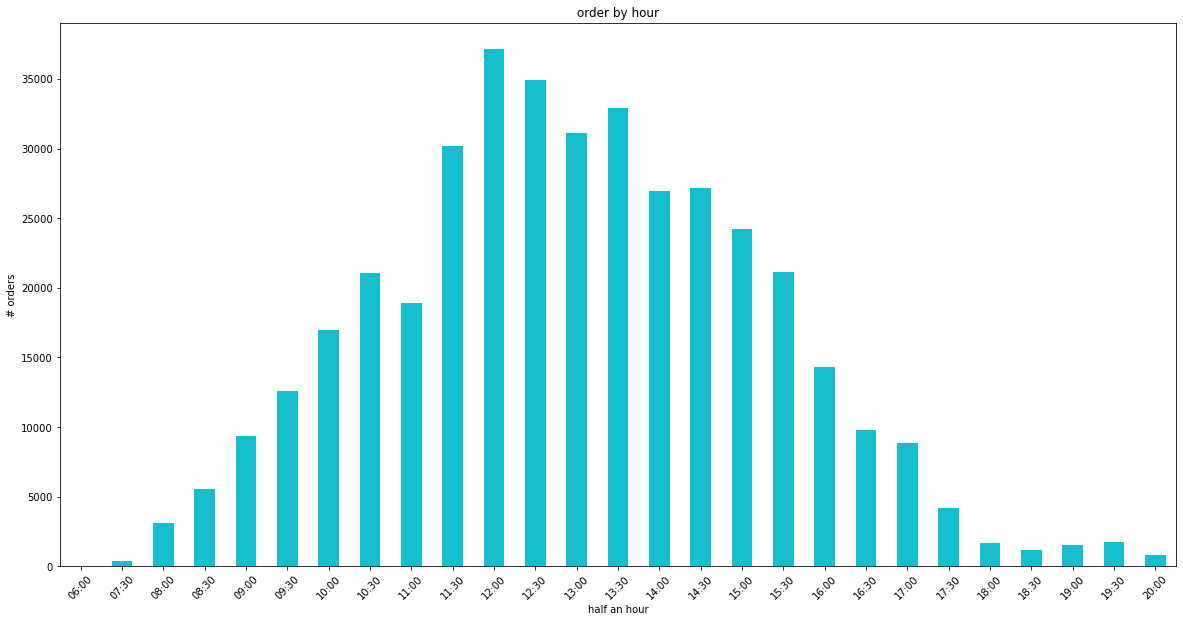

In [11]:
plot_bar(order_by_hour_half, 'half an hour', '# orders', 'order by hour')

In [14]:
order_by_hour_half / order_by_hour_half.sum() 

InvoiceDate
06:00    0.000003
07:30    0.000953
08:00    0.007904
08:30    0.013936
09:00    0.023534
09:30    0.031617
10:00    0.042600
10:30    0.052897
11:00    0.047564
11:30    0.075798
12:00    0.093429
12:30    0.087691
13:00    0.078241
13:30    0.082675
14:00    0.067753
14:30    0.068261
15:00    0.060890
15:30    0.053136
16:00    0.035980
16:30    0.024562
17:00    0.022341
17:30    0.010511
18:00    0.004310
18:30    0.003049
19:00    0.003855
19:30    0.004491
20:00    0.002016
Name: CustomerID, dtype: float64

#### 개인화된 push notification
 - 아마존을 필두로, 개인화(personalization)하여 맞춤으로 사용자마다 최적의 솔루션을 찾는것이 트렌드가 됨
 - 사용자별로 소비의 패턴이 다를 수 있기 때문에, 가장 많이 구매한 시간대를 찾아서 해당 시간대에 쿠폰을 발송!

#### 사용자별 각 시간별 주문 량 계산하기

In [15]:
order_count_by_hour = retail.set_index('InvoiceDate').groupby(['CustomerID', lambda date: date.hour]).count()['StockCode']
order_count_by_hour

CustomerID  InvoiceDate
12346       10              1
12347       8              22
            10             24
            12             47
            13             18
                           ..
18283       15              1
            16             56
            19             87
18287       9               3
            10             67
Name: StockCode, Length: 11205, dtype: int64

In [16]:
order_count_by_hour.loc[12437]

InvoiceDate
9     52
10    21
11    11
13    35
14    15
15    20
16    45
Name: StockCode, dtype: int64

#### 사용자별 최대 주문 시간 계산하기
 - 가장 많은 주문량을 보인 시간을 계산

In [19]:
idx = order_count_by_hour.groupby('CustomerID').idxmax()

#### 해당 시간 indexing

In [22]:
result = order_count_by_hour.loc[idx]
result

CustomerID  InvoiceDate
12346       10               1
12347       14              60
12348       19              17
12349       9               73
12350       16              17
                          ... 
18280       9               10
18281       10               7
18282       13               7
18283       14             201
18287       10              67
Name: StockCode, Length: 4338, dtype: int64

In [27]:
result.reset_index().groupby('level_1').groups

KeyError: 'level_1'